<a href="https://colab.research.google.com/github/AngelPn/Netflix-Data-Analysis/blob/main/netflix_data_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Authors
- 1115201800141 - Αγγελική Παναγοπούλου
- 1115201800142 - Θεοδώρα Παντελιού

# Netflix Data Mining Notebook
This notebook deals with data from a well-known content platform and production company, Netflix. The following questions will be answered:
1. Which type is superior, the movies or the series?
2. Has Netflix invested more in movies or series in recent years?
3. Which country has the most content?
4. What kind of content (genre) does each country have?
5. Plot graphs showing the actors with the most movies in
each country. Do the same for the series.
6. Plot a graph that gathers the number of
movies depending on the suggested age. Do the same for the series.
7. If a producer wanted to have a high audience, he thinks it would
be better to make his film at a time when it does not exist much
competition. Plot a graph with the content added per month
to help him choose the right time period.
8. Prepare a chart that summarizes the kind of content.
9. Plot graphs showing the directors in each country.
10. Plot graphs showing movies analog to number of seasons.
11. Which are the highest rated movies?


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [2]:
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
# For random selection 
import random
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
# For preprocessing
import spacy

import datetime
import scipy.sparse as sp

# Load Dataset
Read the data using pandas read_csv method and control missing data.

In [3]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/netflix_titles.csv'

df = pd.read_csv(Location)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s2  ...  After a devastating earthquake hits Mexico Cit...
2      s3  ...  When an army recruit is found dead, his fellow...
3      s4  ...  In a postapocalyptic world, rag-doll robots hi...
4      s5  ...  A brilliant group of students become card-coun...

[5 rows x 12 columns]

We are going to tackle each question step by step and only in case of need we will dismiss NA objects, in order not to exclude a sizeable portion of the data set.

# Question 1
Which type is superior, the movies or the series?

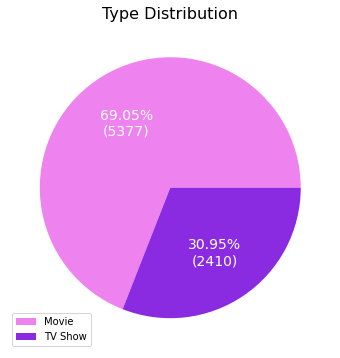

In [ ]:
types = df.groupby('type').size()

types.plot.pie(figsize = (6, 6),
               colors = ['violet', 'blueviolet'],
               textprops = {'fontsize': 14, 'color': 'w'},
               autopct = lambda p : '{:.2f}%\n({:.0f})'.format(p, (p/100)*types.sum()))
plt.title('Type Distribution', fontsize = 16)
plt.axis('off')
plt.legend()
plt.show()

Τhe most common type is 'Movie'.

# Question 2
Has Netflix invested more in movies or series in recent years?

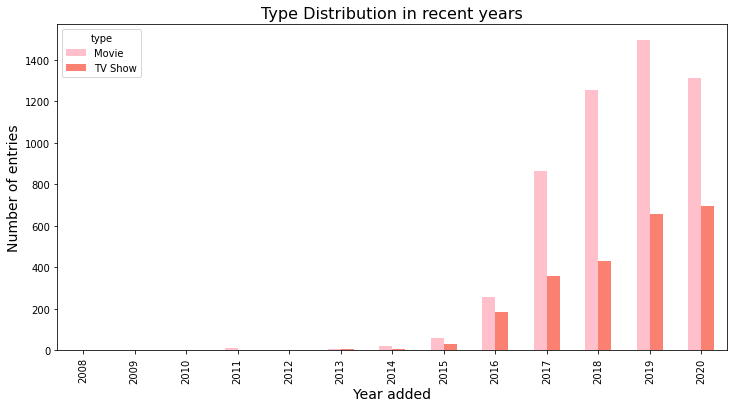

In [ ]:
# Make a list of all years from start_year to current_year (this year)
start_year = 1976
current_year = datetime.datetime.now().year
years = [str(year) for year in range(start_year, current_year)]

# Define pat: regular expression pattern with capturing groups
pat = '|'.join(years) 
# For each subject string in the Series, extract groups from the first match of regular expression pat.
year_added = df['date_added'].str.extract('('+ pat + ')', expand = False)
# Group by year added and type
df_group = df.groupby([year_added, 'type']).size()

df_group.unstack().plot.bar(figsize = (12, 6), color = ['pink', 'salmon'])
plt.title('Type Distribution in recent years', fontsize = 16)
plt.xlabel('Year added', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()

In recent years, Netflix has invested more in movies.

# Question 3
Which country has the most content (movies or series)?

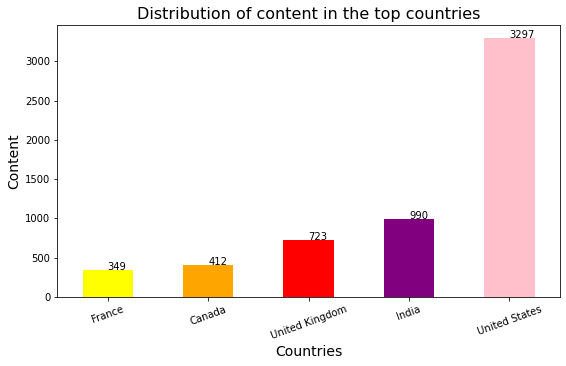

In [ ]:
# Use filter to dismiss NA values from country column
df_fltr = df[~df.country.isna()]

# Explode by country
df_new = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)

content = df_new.groupby(by = 'country')['show_id'].count().sort_values().tail(5)

content.plot.bar(color = ['yellow', 'orange', 'red', 'purple', 'pink'], figsize = (9, 5), rot = 0)
for index, value in enumerate(list(content)):
    plt.text(index, value, str(value))
plt.title('Distribution of content in the top countries', fontsize = 16)
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Countries', fontsize = 14)
plt.ylabel('Content', fontsize = 14)
plt.show()

United States has the most content with 3297 movies or TV shows.

# Question 4
What kind of content (genre) does each country have?

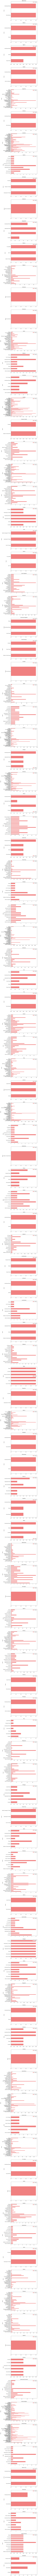

In [ ]:
# Use filter to dismiss NA values from country and listed_in columns
df_fltr = df[(~df.country.isna()) & (~df.listed_in.isna())]

# Explode by country and listed_in
df_new = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
df_new = df_new.assign(listed_in = df_new['listed_in'].str.strip().str.split(', ')).explode('listed_in').reset_index(drop = True)

# Group new dataframe by country and listed_in
df_group = df_new.groupby(['listed_in','country']).size().unstack()

cols = df_group.columns
fig, axes = plt.subplots(nrows = len(cols), ncols = 1, figsize = (8, 800))

# For each of the countries, plot a dataframe showing the distribution of genre in country
for idx, country in enumerate(cols):  
  res = df_group[country].reset_index([0, 'listed_in'])
  res.columns = ['Genre', 'Entries']
  res = res[~res['Entries'].isna()] # keep only the entries of genre that have values
  res.plot.barh(x = 'Genre', ax = axes[idx], color = ['lightcoral'], title = country)

plt.show()


The graphs show the distribution of kind of content (genre) for each country.

# Question 5
Plot graphs showing the actors with the most movies in each country. Do the same for the series.

In [ ]:
# Use filter to dismiss NA values from country and cast columns
df_fltr = df[~df.country.isna() & ~df.cast.isna()]

# Explode by country and cast
new_df = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
new_df = new_df.assign(cast = new_df['cast'].str.strip().str.split(', ')).explode('cast').reset_index(drop = True)
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67592 entries, 0 to 67591
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       67592 non-null  object
 1   type          67592 non-null  object
 2   title         67592 non-null  object
 3   director      49523 non-null  object
 4   cast          67592 non-null  object
 5   country       67592 non-null  object
 6   date_added    67524 non-null  object
 7   release_year  67592 non-null  int64 
 8   rating        67553 non-null  object
 9   duration      67592 non-null  object
 10  listed_in     67592 non-null  object
 11  description   67592 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.2+ MB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s1  ...  In a future where the elite inhabit an island ...
2      s1  ...  In a future where the elite inhabit an island ...
3      s1  ...  In a future where the elite inhabit an island ...
4      s1  ...  In a future where the elite inhabit an island ...

[5 rows x 12 columns]

## For movies
Τhe top 5 actors with the most movies in each country.

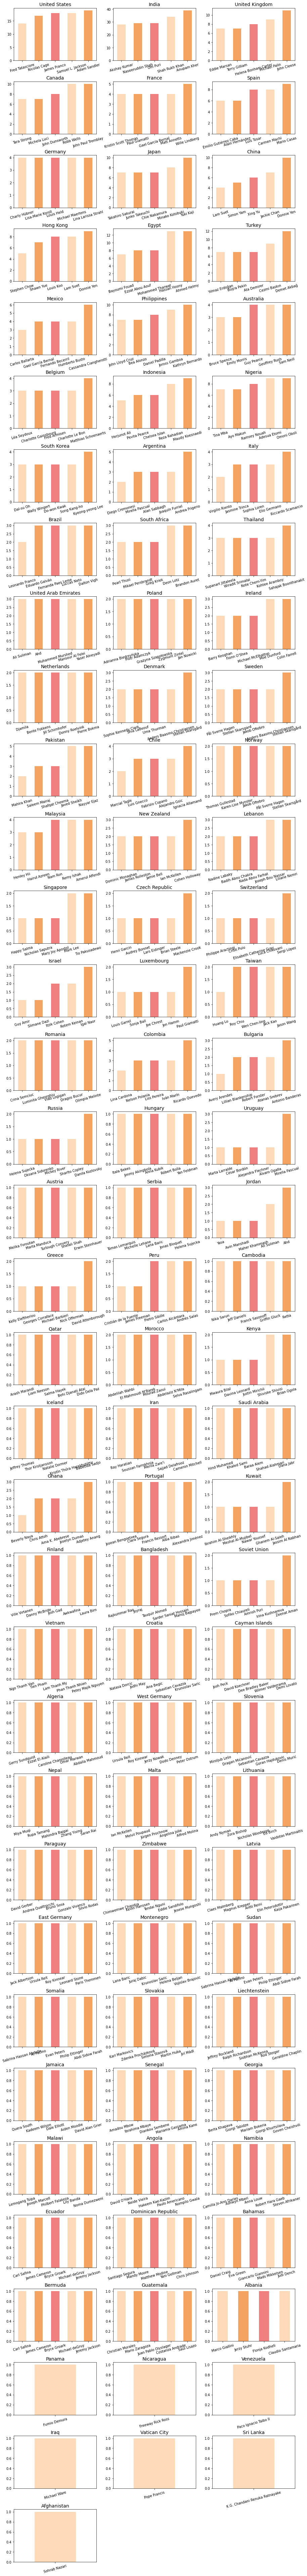

In [ ]:
countries_with_movies = new_df[new_df['type'] == 'Movie']['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 140))

for idx, country in enumerate(countries_with_movies):
  ax = fig.add_subplot(35, 3, idx+1)
  result = new_df.loc[(new_df['country'] == country) & (new_df['type'] == 'Movie')]['cast'].value_counts().sort_values().tail(5)
  result.plot.bar(color = ['peachpuff', 'sandybrown', 'lightcoral'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(hspace = 0.4)
plt.show()

## For series
The top 5 actors with the most series in each country.

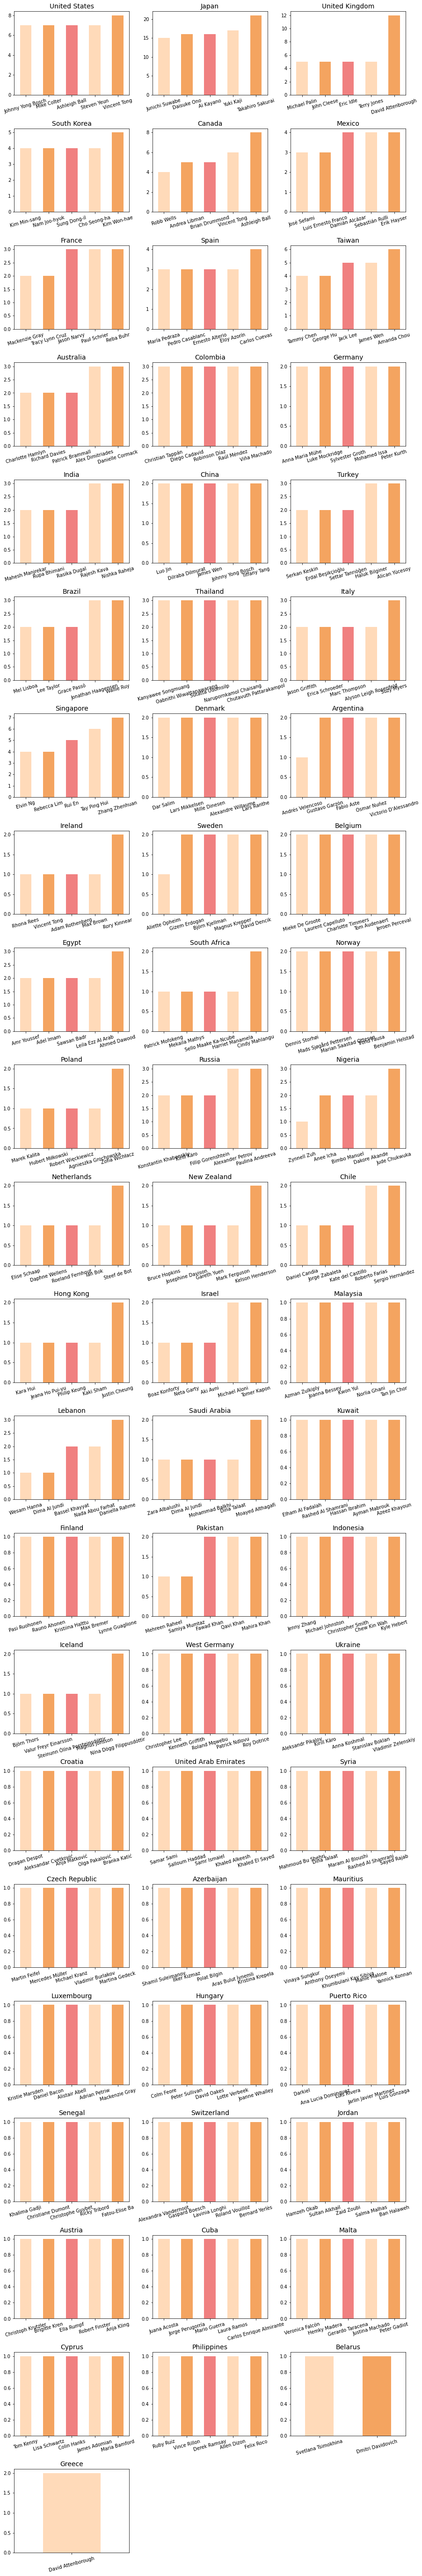

In [ ]:
countries_with_series = new_df[new_df['type'] == 'TV Show']['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 100))

for idx, country in enumerate(countries_with_series):
  ax = fig.add_subplot(22, 3, idx+1)
  result = new_df.loc[(new_df['country'] == country) & (new_df['type'] == 'TV Show')]['cast'].value_counts().sort_values().tail(5)
  result.plot.bar(color = ['peachpuff', 'sandybrown', 'lightcoral'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(hspace = 0.4)
plt.show()

# Question 6
Plot a graph that gathers the number of movies depending on the suggested age. Do the same for the series.

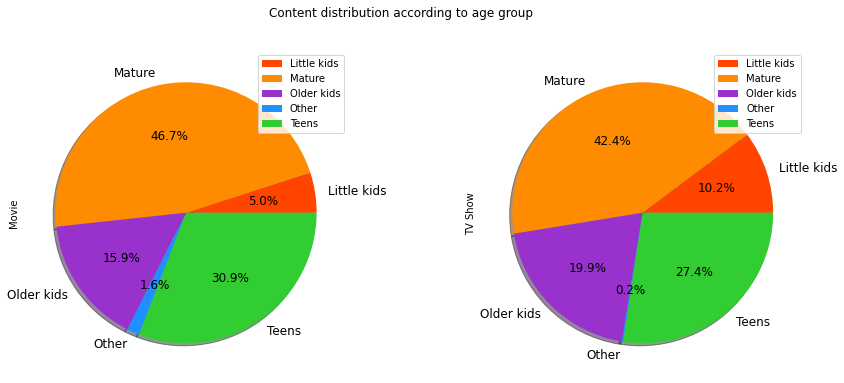

In [ ]:
little_kids = ['G', 'TV-Y', 'TV-G']
older_kids = ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']
teens = ['PG-13', 'TV-14']
mature = ['R', 'NC-17', 'TV-MA']
rating_list = [little_kids, older_kids, teens, mature]
rating_names = ['Little kids', 'Older kids', 'Teens', 'Mature']

# Use filter to dismiss NA values from rating column
df_fltr = df[~df['rating'].isna()]
# Return an array drawn from elements in choicelist (rating_names), depending on conditions.
age_group = np.select([df_fltr['rating'].isin(categ) for categ in rating_list],
                      rating_names,
                      'Other')
# Group by age group and type
df_group = df_fltr.groupby([age_group,'type']).size().unstack(fill_value = 0)

df_group.plot.pie(subplots = True, 
                  figsize = (15, 6), 
                  shadow = True, 
                  legend = True, 
                  autopct = '%1.1f%%',
                  textprops = {'fontsize':12},
                  colors = ['orangered', 'darkorange', 'darkorchid', 'dodgerblue', 'limegreen'],
                  title = "Content distribution according to age group")

plt.show()

Based on the graphs, Netflix does not provide rich content for all ages, because of the small percentage of content for Little kids and Older kids, both for Movie and TV Show type of content.

# Question 7
If a producer wanted to have a high audience, he thinks it would be better to make his film at a time when it does not exist much competition. Plot a graph with the content added per month to help him choose the right time period.

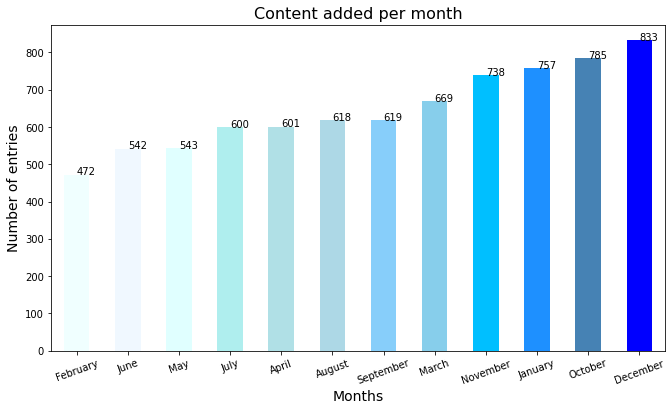

In [ ]:
# Use filter to dismiss NA values from date_added column
df_fltr = df[~df.date_added.isna()]

# Create a new dataframe from the series with show_id as the index extracting months
df_new = pd.DataFrame(df_fltr.date_added.str.strip().str.partition(" ")[0].tolist(), index = df_fltr.show_id).stack()
df_new = df_new.reset_index([0, 'show_id'])
df_new.columns = ['show_id', 'month']

# Group by month and count entries
df_group = df_new.groupby('month')['show_id'].count().sort_values()

df_group.plot.bar(figsize = (11, 6), 
                  rot = 0, 
                  color = ['azure', 'aliceblue', 'lightcyan', 'paleturquoise', 'powderblue', 'lightblue', 
                          'lightskyblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'steelblue', 'blue'])
for index, value in enumerate(list(df_group)):
    plt.text(index, value, str(value))
plt.title('Content added per month', fontsize = 16)
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Months', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()


According to plot graph, the producer should make his film in February.

# Question 8
Prepare a chart that summarizes the kind of content (listed_in column).

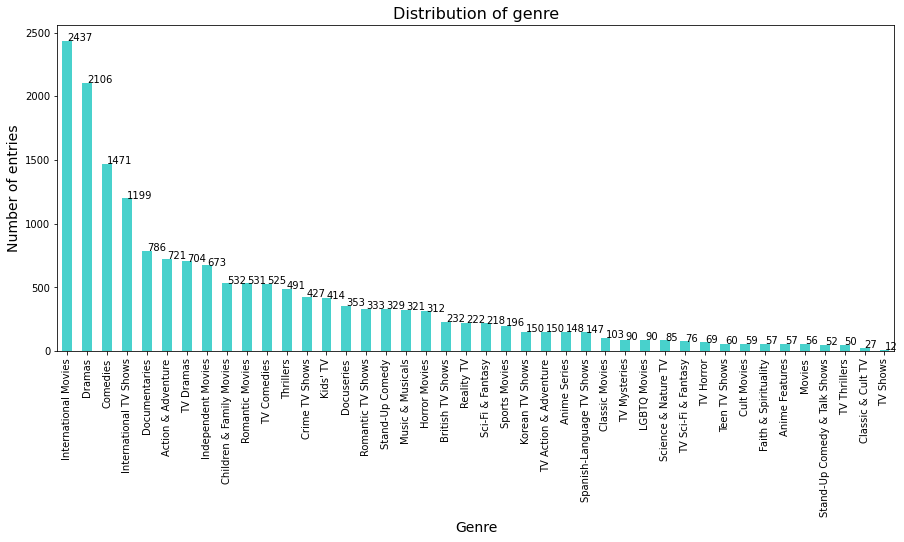

In [ ]:
# Use filter to dismiss NA values from listed_in column
df_fltr = df[~df['listed_in'].isna()]

# Explode by kind of content (listed_in columns)
df_new = df_fltr.assign(listed_in = df_fltr['listed_in'].str.strip().str.split(', ')).explode('listed_in').reset_index(drop = True)

# Group by listed_in column and count number of entries
df_new = df_new.groupby('listed_in').size().sort_values(ascending = False)
df_new.plot.bar(figsize = (15, 6), color = 'mediumturquoise')
for index, value in enumerate(list(df_new)):
    plt.text(index, value, str(value))
plt.title('Distribution of genre', fontsize = 16)
plt.xlabel('Genre', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()

# Question 9
Plot graphs showing the directors in each country.

In [ ]:
# Use filter to dismiss NA values from country and director columns
df_fltr = df[(~df.country.isna()) & (~df.director.isna())]

# Explode by country and director
new_df = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
new_df = new_df.assign(director = new_df['director'].str.strip().str.split(', ')).explode('director').reset_index(drop = True)

new_df.info()
new_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7590 entries, 0 to 7589
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7590 non-null   object
 1   type          7590 non-null   object
 2   title         7590 non-null   object
 3   director      7590 non-null   object
 4   cast          6928 non-null   object
 5   country       7590 non-null   object
 6   date_added    7590 non-null   object
 7   release_year  7590 non-null   int64 
 8   rating        7586 non-null   object
 9   duration      7590 non-null   object
 10  listed_in     7590 non-null   object
 11  description   7590 non-null   object
dtypes: int64(1), object(11)
memory usage: 711.7+ KB


show_id  ...                                        description
0      s2  ...  After a devastating earthquake hits Mexico Cit...
1      s3  ...  When an army recruit is found dead, his fellow...
2      s4  ...  In a postapocalyptic world, rag-doll robots hi...
3      s5  ...  A brilliant group of students become card-coun...
4      s6  ...  A genetics professor experiments with a treatm...

[5 rows x 12 columns]

## Top directors in each country
Plot graphs showing top 5 directors in each country analog to the number of movies or series they have participated. 



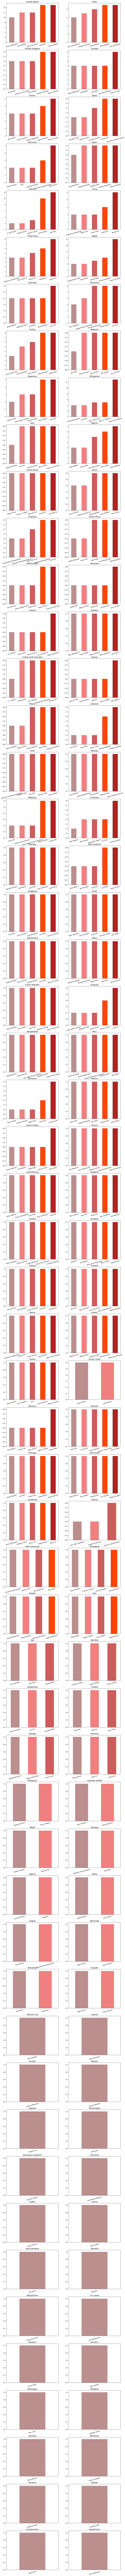

In [ ]:
countries_with_directors = new_df['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 140))

for idx, country in enumerate(countries_with_directors):
  ax = fig.add_subplot(len(countries_with_directors)/2, 2, idx+1)
  result = new_df.loc[(new_df['country'] == country)]['director'].value_counts().sort_values().tail(5)
  result.plot.bar(color = ['rosybrown', 'lightcoral', 'indianred', 'orangered', 'firebrick'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(top = 2.0)
plt.show()

## Number of directors in each country

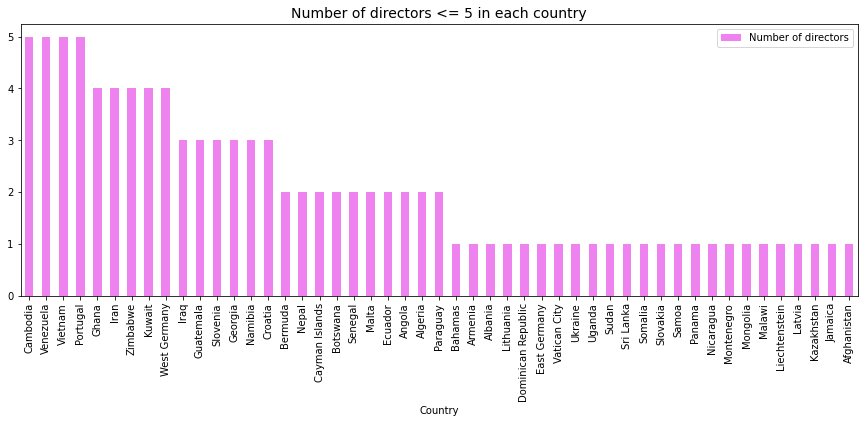

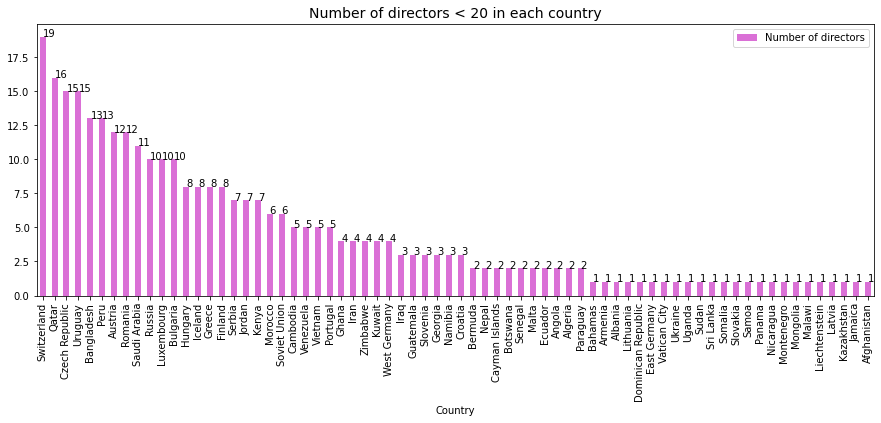

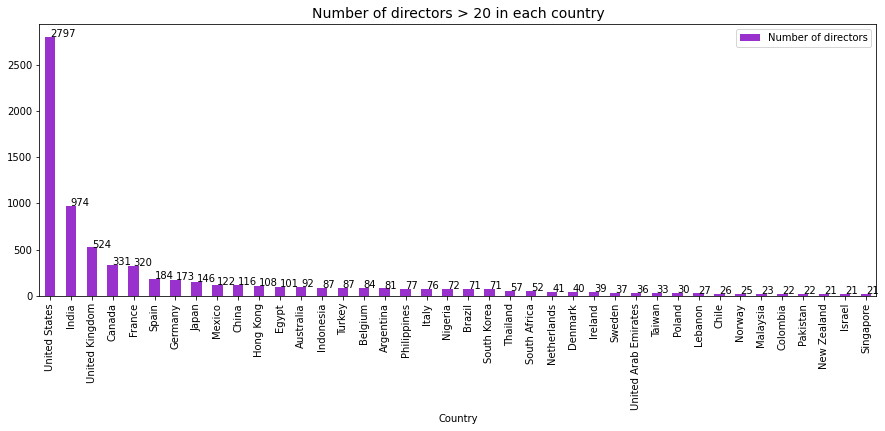

In [ ]:
# Get dataframe grouped by country and count directors
df_group = new_df.groupby(by = ['country'])['director'].count().sort_values(ascending = False)
df_group = df_group.reset_index([0, 'country'])
df_group.columns = ['Country', 'Number of directors']

df_group.loc[df_group['Number of directors'] <= 5].plot.bar(x = 'Country', y = 'Number of directors', figsize = (15, 5), color = 'violet')
plt.title('Number of directors <= 5 in each country', fontsize = 14)

df_group2 = df_group.loc[df_group['Number of directors'] <= 20]
df_group2.plot.bar(x = 'Country', y = 'Number of directors', figsize = (15, 5), color = 'orchid')
plt.title('Number of directors < 20 in each country', fontsize = 14)
for index, value in enumerate(list(df_group2['Number of directors'])):
    plt.text(index, value, str(value))

df_group3 = df_group.loc[df_group['Number of directors'] > 20]
df_group3.plot.bar(x = 'Country', y = 'Number of directors', figsize = (15, 5), color = 'darkorchid')
plt.title('Number of directors > 20 in each country', fontsize = 14)
for index, value in enumerate(list(df_group3['Number of directors'])):
    plt.text(index, value, str(value))

plt.show()


# Question 10
Plot graphs showing TV shows analog to number of seasons.

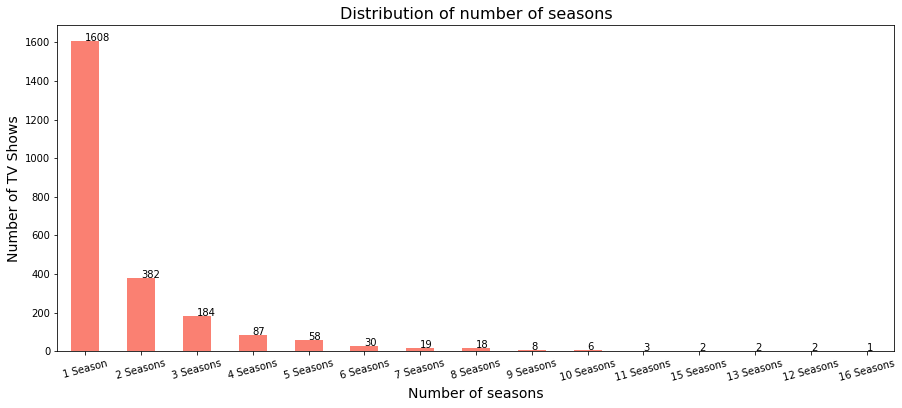

In [ ]:
# Use filter to dismiss NA values from duration column
df_new = df[~df.duration.isna()]
# Get dataframe only with TV shows
df_new = df_new[df_new['type'] == 'TV Show']

# Group by duration and count the number of TV shows
df_group = df_new.groupby('duration').size().sort_values(ascending = False)
df_group.plot.bar(figsize = (15, 6), color = 'salmon')
for index, value in enumerate(list(df_group)):
    plt.text(index, value, str(value))
plt.xticks(rotation = 15)
plt.title('Distribution of number of seasons', fontsize = 16)
plt.xlabel('Number of seasons', fontsize = 14)
plt.ylabel('Number of TV Shows', fontsize = 14)
plt.show()

# Question 11
Which are the highest rated movies?

Load datasets imdb movies and imbd ratings

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/IMDb ratings.csv'
df_imdbratings = pd.read_csv(Location)
df_imdbratings.info()
df_imdbratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              85855 non-null  object 
 1   weighted_average_vote      85855 non-null  float64
 2   total_votes                85855 non-null  int64  
 3   mean_vote                  85855 non-null  float64
 4   median_vote                85855 non-null  float64
 5   votes_10                   85855 non-null  int64  
 6   votes_9                    85855 non-null  int64  
 7   votes_8                    85855 non-null  int64  
 8   votes_7                    85855 non-null  int64  
 9   votes_6                    85855 non-null  int64  
 10  votes_5                    85855 non-null  int64  
 11  votes_4                    85855 non-null  int64  
 12  votes_3                    85855 non-null  int64  
 13  votes_2                    85855 non-null  int

imdb_title_id  ...  non_us_voters_votes
0     tt0000009  ...                 70.0
1     tt0000574  ...                331.0
2     tt0001892  ...                123.0
3     tt0002101  ...                105.0
4     tt0002130  ...               1166.0

[5 rows x 49 columns]

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/IMDb movies.csv'
df_imdbmovies = pd.read_csv(Location)
df_imdbmovies.info()
df_imdbmovies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


imdb_title_id  ... reviews_from_critics
0     tt0000009  ...                  2.0
1     tt0000574  ...                  7.0
2     tt0001892  ...                  2.0
3     tt0002101  ...                  3.0
4     tt0002130  ...                 14.0

[5 rows x 22 columns]

Create and print dataframe that keeps netflix movies for which have ratings on the IMBD.

In [ ]:
# Merge imdb movies with imdb ratings to add the weighted average vote column
df_imdb = pd.merge(df_imdbmovies, df_imdbratings[['imdb_title_id', 'weighted_average_vote']],
                   on = ['imdb_title_id'], 
                   how = 'inner')

# Match netflix titles with imdb's titles with same release year
df_match_titles = pd.merge(df, df_imdb[['imdb_title_id', 'title', 'year', 'weighted_average_vote']],
                           left_on=['title', 'release_year'],
                           right_on=['title', 'year'],
                           how='inner')

# Match netflix titles with imdb's original title with same release year
df_match_originaltitles = pd.merge(df, df_imdb[['imdb_title_id', 'original_title', 'year', 'weighted_average_vote']],
                                   left_on=['title', 'release_year'],  
                                   right_on=['original_title', 'year'],
                                   how='inner')

# Outer join dataframes that matched titles and original titles with netflix
df_matchtitles = pd.merge(df_match_titles[['imdb_title_id', 'title', 'weighted_average_vote']], 
                          df_match_originaltitles[['imdb_title_id', 'original_title', 'weighted_average_vote']], 
                          on = ['imdb_title_id', 'weighted_average_vote'],
                          how = 'outer')

# Keep subset of dataframe that has NA in title
df_original_title = df_matchtitles[df_matchtitles.title.isna()][['original_title', 'weighted_average_vote']]
df_original_title.columns = ['title', 'weighted_average_vote']

# Keep subset of dataframe that has non-NA in title
df_title = df_matchtitles[~df_matchtitles.title.isna()][['title', 'weighted_average_vote']]

# Concat the above subsets of dataframe
df_ratings = pd.concat([df_original_title, df_title])
df_ratings.reset_index(inplace = True, drop = True)

df_ratings.info()
df_ratings.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  1038 non-null   object 
 1   weighted_average_vote  1038 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.3+ KB


title  weighted_average_vote
0  Çok Filim Hareketler Bunlar                    4.4
1                1 Mile to You                    6.3
2               10 jours en or                    5.9
3                      13 Sins                    6.3
4                    16 Blocks                    6.6
5                     17 Again                    6.3
6                    21 & Over                    5.8
7                      28 Days                    6.1
8               50 First Dates                    6.8
9                        50/50                    7.6

Find top 20 netflix movies or series based on IMDb weigted average vote.

In [ ]:
top_ratings = df_ratings.sort_values(by='weighted_average_vote', ascending=False).head(20)
top_ratings

title  weighted_average_vote
832                                   Pulp Fiction                    8.9
873                               Schindler's List                    8.9
338  The Lord of the Rings: The Return of the King                    8.9
662                                      Inception                    8.8
343                                     The Matrix                    8.7
339          The Lord of the Rings: The Two Towers                    8.7
534                                    City of God                    8.6
803                          Oththa Seruppu Size 7                    8.6
704                                        Koshish                    8.6
613                                       Gol Maal                    8.6
502                                   Black Friday                    8.5
305                                   The Departed                    8.5
461                             American History X                    8.5
423                                       3 Idiots                    8.4
566                               Django Unchained                    8.4
866                                          Sadma                    8.4
750                                         Masoom                    8.4
278                               Taare Zameen Par                    8.4
12                              A Clockwork Orange                    8.3
460                                American Beauty                    8.3

Plot graph showing the top 20 netflix movies or series based on IMDb weigted average vote.

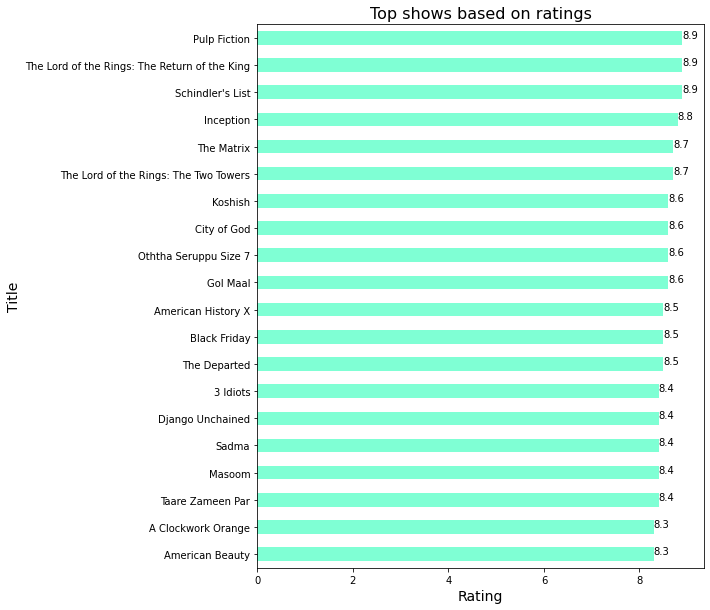

In [ ]:
# Plot top ratings
top_ratings = top_ratings.sort_values(by='weighted_average_vote')
top_ratings.plot.barh(x = 'title', figsize = (8, 10), color = 'aquamarine', legend=False)
for index, value in enumerate(list(top_ratings['weighted_average_vote'])):
    plt.text(value, index, str(value))
plt.title('Top shows based on ratings', fontsize = 16)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Title', fontsize = 14)
plt.show()

# Recommendation system
Creates a system that recommends top N similar movies/TV shows.

In [4]:
# Create a new dataframe containing only the info show_id, title, description
df_sub = df[['show_id', 'title', 'description']]

# Use filter to dismiss NA values from title column
# no need to dismiss NA values from description column because title is used for recommendation
df_sub = df_sub[~df_sub.title.isna()]

df_sub.info()
df_sub.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7787 entries, 0 to 7786
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      7787 non-null   object
 1   title        7787 non-null   object
 2   description  7787 non-null   object
dtypes: object(3)
memory usage: 243.3+ KB


show_id  title                                        description
0      s1     3%  In a future where the elite inhabit an island ...
1      s2   7:19  After a devastating earthquake hits Mexico Cit...
2      s3  23:59  When an army recruit is found dead, his fellow...
3      s4      9  In a postapocalyptic world, rag-doll robots hi...
4      s5     21  A brilliant group of students become card-coun...

## Preprocessing
Τhe preprocessing is performed using the spaCy library of python as follows:
* Tokenization
* Lemmatization: using spaCy's built-in methods.
* Converting all the words to lower case
* Stopword Removal: using the "is_stop" attribute of the token object.
* Removing Punctuations: using "isalpha" method of string objects.

In [5]:
# Instantiate English module
nlp = spacy.load("en_core_web_sm")

lemmas = []
for i, row in df_sub.iterrows():
  # Create doc object from title and description
  doc = nlp(row['title']+' '+row['description'])
  # Filter our tokens
  lemmatized = [token.lemma_ for token in doc if (token.is_stop == False and token.text.isalpha() == True)]
  lemmas.append(' '.join(lemmatized))

df_sub.insert(len(df_sub.columns), 'lemmas', lemmas, True)
df_sub.head()


show_id  ...                                             lemmas
0      s1  ...  future elite inhabit island paradise far crowd...
1      s2  ...  devastating earthquake hit Mexico City trap su...
2      s3  ...  army recruit find dead fellow soldier force co...
3      s4  ...  postapocalyptic world rag doll robot hide fear...
4      s5  ...  brilliant group student card count expert inte...

[5 rows x 4 columns]

## Boolean Bag-of-Words
Convert a collection of text documents to a matrix of token counts with CountVectorizer.
Set 'min_df = 2' to build the vocabulary ignoring terms that have a document frequency strictly lower than the given threshold. This value is a cut-off. It provides better recommendation results rather than keeping the default value, because more same titles are produced between the two methods.

In [13]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=2, stop_words='english', binary=True)

bow_representation = bow_vectorizer.fit_transform(df_sub.lemmas)

print(bow_vectorizer.get_feature_names())
print(bow_representation.toarray())
print(bow_representation.shape)


['aagey', 'aamir', 'aamir khan', 'aapke', 'aaron', 'aaron paul', 'aata', 'abandon', 'abandon hotel', 'abandon young', 'abbey', 'abby', 'abcd', 'abduct', 'abducted', 'abduction', 'abductor', 'abdullah', 'abel', 'abide', 'ability', 'ability chase', 'able', 'able learn', 'abnormal', 'abnormal summit', 'aboard', 'aboard spaceship', 'abortion', 'abound', 'abound detective', 'abrazo', 'abroad', 'abruptly', 'absence', 'absorb', 'abstract', 'absurd', 'absurdity', 'abu', 'abu dhabi', 'abuja', 'abuse', 'abuse child', 'abusive', 'abusive ex', 'abusive husband', 'abyss', 'academic', 'academy', 'academy award', 'academy student', 'acapulco', 'accent', 'accept', 'accept help', 'accept invitation', 'acceptance', 'access', 'access pass', 'accident', 'accident couple', 'accident leave', 'accident man', 'accident murder', 'accident send', 'accidental', 'accidentally', 'accidentally kill', 'acclaim', 'acclaimed', 'accompany', 'accomplice', 'accomplished', 'accomplishment', 'accord', 'account', 'accountan

## Term Frequency - Inverse Document Frequency
Convert a collection of raw documents to a matrix of TF-IDF features with TfidfVectorizer. Set 'min_df = 2' to build the vocabulary ignoring terms that have a document frequency strictly lower than the given threshold. This value is a cut-off. It provides better recommendation results rather than keeping the default value, because more same titles are produced between the two methods.

In [27]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=2, stop_words='english')

tfidf_representation = tfidf_vectorizer.fit_transform(df_sub.lemmas)

print(tfidf_vectorizer.get_feature_names())
print(tfidf_representation.toarray())
print(tfidf_representation.shape)


['aagey', 'aamir', 'aamir khan', 'aapke', 'aaron', 'aaron paul', 'aata', 'abandon', 'abandon hotel', 'abandon young', 'abbey', 'abby', 'abcd', 'abduct', 'abducted', 'abduction', 'abductor', 'abdullah', 'abel', 'abide', 'ability', 'ability chase', 'able', 'able learn', 'abnormal', 'abnormal summit', 'aboard', 'aboard spaceship', 'abortion', 'abound', 'abound detective', 'abrazo', 'abroad', 'abruptly', 'absence', 'absorb', 'abstract', 'absurd', 'absurdity', 'abu', 'abu dhabi', 'abuja', 'abuse', 'abuse child', 'abusive', 'abusive ex', 'abusive husband', 'abyss', 'academic', 'academy', 'academy award', 'academy student', 'acapulco', 'accent', 'accept', 'accept help', 'accept invitation', 'acceptance', 'access', 'access pass', 'accident', 'accident couple', 'accident leave', 'accident man', 'accident murder', 'accident send', 'accidental', 'accidentally', 'accidentally kill', 'acclaim', 'acclaimed', 'accompany', 'accomplice', 'accomplished', 'accomplishment', 'accord', 'account', 'accountan

## Similar movies

### Jaccard/Tanimoto coefficiency for BoW

In [30]:
# Jaccard similarity function
def jaccard_similarity(X, Y=None):
    """
    Computes the Jaccard score between two sparse matrices or between all pairs in
    one sparse matrix.

    Args:
        X (scipy.sparse.csr_matrix): A sparse matrix.
        Y (scipy.sparse.csr_matrix, optional): A sparse matrix.

    Returns:
        numpy.ndarray: A similarity matrix.
    """

    if Y is None:
        Y = X

    assert X.shape[1] == Y.shape[1] # columns of X must be equal to columns of Y
    # make arrays boolean 
    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)

    intersect = X.dot(Y.T)

    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)

    return (intersect / union).A
    
# Use of jaccard_similarity func to return an array containing the jaccard similarities of the rows of array. 
# The value in the i-th row and j-th column of the result is the jaccard similarity between the i-th and j-th row of array.
jaccard_similarities = jaccard_similarity(bow_representation)

print(jaccard_similarities)


[[1.         0.         0.03571429 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.05405405 0.         0.        ]
 [0.03571429 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.05405405 0.         ... 1.         0.         0.0625    ]
 [0.         0.         0.         ... 0.         1.         0.03846154]
 [0.         0.         0.         ... 0.0625     0.03846154 1.        ]]


### Cosine similarity for TF-IDF

In [31]:
# Use of cosine_similarity to return an array containing the cosine similarities of the rows of array. 
# The value in the i-th row and j-th column of the result is the cosine similarity between the i-th and j-th row of array.
cosine_similarities = cosine_similarity(tfidf_representation)

print(cosine_similarities)

[[1.         0.         0.05469065 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.05646939 0.         0.        ]
 [0.05469065 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.05646939 0.         ... 1.         0.         0.08401613]
 [0.         0.         0.         ... 0.         1.         0.03648901]
 [0.         0.         0.         ... 0.08401613 0.03648901 1.        ]]


For each method, get the N indices with the maximum similarities. Identify each title by its index in dataframe.

In [32]:
def topN_val_indices(similarities, N = 100):
  # Fill diagonal with zeros in order to not recommend the same movie/TV show
  np.fill_diagonal(similarities, 0.0)

  # Initialize numpy array to keep indices of N maximum values from 'similarities' numpy array
  top_val_indices = np.zeros(shape = (len(similarities), N))

  # For each of title index and its scores in 'similarities'
  for title_index, scores in enumerate(similarities):
    idx = np.argpartition(scores, -N)[-N:] # get the indices of the N maximum values
    indices = idx[np.argsort((-scores)[idx])] # get the top-N elements in sorted order
    top_val_indices[title_index] = indices # store indices for title_index

  return top_val_indices


bowN_val_indices = topN_val_indices(jaccard_similarities)
tfidfN_val_indices = topN_val_indices(cosine_similarities)

print(bowN_val_indices)
print('\n')
print(tfidfN_val_indices)

[[5589. 1698.  575. ...  189. 6114. 5545.]
 [3537. 5189. 3847. ... 2106. 5621. 3705.]
 [1190. 5683. 4869. ... 6653. 2336. 4523.]
 ...
 [5038. 1705. 7291. ... 6200.  863. 2215.]
 [3004. 6087. 4387. ... 2229. 2199. 5918.]
 [3378. 6866. 4558. ... 2655. 7105. 6514.]]


[[2172. 3069. 5821. ... 6484.  865. 5860.]
 [2564. 6269. 4752. ... 2854. 2067. 2294.]
 [1190. 6283. 5683. ...  785. 2095. 6520.]
 ...
 [5034. 5536. 5038. ... 3791.  281.  443.]
 [7628. 1279. 4387. ... 4118. 6802. 5575.]
 [5242. 5103. 3378. ... 5106. 1894.  467.]]


For each movie, find the top 100 similar movies and store this information to a dictionary.

In [33]:
# Dictionaries with key a movie title and value a list with the top N similar movies
bow_similars = {}
tfidf_similars = {}

for i, row in df_sub.iterrows():

  bow_similars[row['title']] = []
  tfidf_similars[row['title']] = []

  for j in bowN_val_indices[i]:
    similar_movie = df_sub.iloc[int(j)]['title']
    bow_similars[row['title']].append(similar_movie)

  for j in tfidfN_val_indices[i]:
    similar_movie = df_sub.iloc[int(j)]['title']
    tfidf_similars[row['title']].append(similar_movie)


## Reccomendation

### Get similar movies depending on a title

Look up the movie/tv show title in the method's (boolean bow or tf-idf) dictionary and print the top N in that list. 

In [34]:
def get_similar_movies1(title, N = 10, method = 'boolean'):
  if method == 'boolean':
    if title in bow_similars:
      print("Suggested movies for '" + title + "' with 'boolean' method:")
      for i in range(N):
        print(str(i + 1) + '. ' + bow_similars[title][i])
    else:
      print("Movie doesn't exist. Choose different movie")
  elif method == 'tf-idf':
    if title in tfidf_similars:
      print("Suggested movies for '" + title + "' with 'tf-idf' method:")
      for i in range(N):
        print(str(i + 1) + '. ' + tfidf_similars[title][i])
    else:
      print("Movie doesn't exist. Choose different movie")
  else:
    print("Invalid method. Choose tf-idf or boolean.")


Some examples:

In [35]:
get_similar_movies1('American Beauty', 10)
print("\n")
get_similar_movies1('American Beauty', 10, 'tf-idf')
print("\n")

get_similar_movies1('Inception', 10)
print("\n")
get_similar_movies1('Inception', 10, 'tf-idf')
print("\n")

get_similar_movies1('You', 10, method='boolean')
print("\n")
get_similar_movies1('You', 10, method='tf-idf')
print("\n")


Suggested movies for 'American Beauty' with 'boolean' method:
1. A Chaster Marriage
2. Santo Cachón
3. Brown Nation
4. Rainbow Time
5. Fractured
6. Drunk Parents
7. Echcharikkai
8. Never Have I Ever
9. Go Karts
10. The Titan


Suggested movies for 'American Beauty' with 'tf-idf' method:
1. A Chaster Marriage
2. Rainbow Time
3. Drunk Parents
4. Thottappan
5. Go Karts
6. The Boy Who Harnessed the Wind
7. Beauty and the Bitches
8. Ghulam-E-Musthafa
9. The Titan
10. The Nut Job


Suggested movies for 'Inception' with 'boolean' method:
1. Apollo 18
2. Til Death Do Us Part
3. Candyflip
4. Backfire
5. Transformers: Cyberverse
6. Maniac
7. Forbidden Planet
8. ANIMA
9. Dark
10. Abby Sen


Suggested movies for 'Inception' with 'tf-idf' method:
1. Apollo 18
2. Til Death Do Us Part
3. Transformers: Cyberverse
4. Candyflip
5. Abby Sen
6. Maniac
7. Black Mirror
8. Dark
9. ANIMA
10. Altered Carbon


Suggested movies for 'You' with 'boolean' method:
1. The Motive
2. Burning
3. Strangers from Hell
4. T

As shown by the results, some of the recommended movies or series are same for both boolean and tf-idf methods.

For instance, as for the movie 'Inception', there are just two different titles out of ten between these two methods. As for the movie 'American Beauty', there are five different recommended titles out of ten. Worth noting that when parameter 'min_df = 1' in CountVectorizer/TfidfVectorizer, there are seven different titles for the movie 'American Beauty'. 

The experimentation of accuracy of recommendation system is based on the number of same titles between the two methods, because we could not know if the recommeded titles are actually similar to the given title.

### Get similar movies depending on a text

In [36]:
def get_similar_movies2(text, N = 10, method = 'boolean'):
  print("Description given: '" + text + "'")
  
  # Preprocessing of text using the spaCy library
  doc = nlp(text)
  lemmatized = [token.lemma_ for token in doc if (token.is_stop == False and token.text.isalpha() == True)]
  lemmatized_text = ' '.join(lemmatized)

  # sim is array of similarities (jaccard or cosine)
  if method == 'boolean':
    print("Suggested movies with 'boolean' method:")
    bow_vectorizer.fit(df_sub.lemmas) # build the vocab
    new_bow_representation = bow_vectorizer.transform([lemmatized_text]) # transform text into a vector using the vocab fitted with fit
    sim = jaccard_similarity(new_bow_representation, bow_representation) # get jaccard similarity of representations
  elif method == 'tf-idf':
    print("Suggested movies for 'tf-idf' method:")
    tfidf_vectorizer.fit(df_sub.lemmas) # build the vocab
    new_tfidf_representation = tfidf_vectorizer.transform([lemmatized_text]) # transform text into a vector using the vocab fitted with fit
    sim = cosine_similarity(new_tfidf_representation, tfidf_representation) # get cosine similarity of representations
  else:
    print("Invalid method. Choose tf-idf or boolean.")
    return 
    
  # Output of cosine_similarity and jaccard_similarity is a 2-d array. In this case it has only one row
  # Make a flat array of similarities out of a 2-d array that has only one row
  sim = sim.flatten() 
  # Get the N indices with the maximum similarities.
  idx = np.argpartition(sim, -N)[-N:]
  indices = idx[np.argsort((-sim)[idx])]

  for n, i in enumerate(indices):
    print(str(n + 1) + '. ' + df_sub.iloc[int(i)]['title'])


Some examples:

In [37]:
text = "While struggling to endure his tightly wound wife, an unfulfilling job and a surly teen, a man becomes obsessed with one of his daughter's friends"
get_similar_movies2(text, method='boolean')
print("\n")
get_similar_movies2(text, method='tf-idf')

Description given: 'While struggling to endure his tightly wound wife, an unfulfilling job and a surly teen, a man becomes obsessed with one of his daughter's friends'
Suggested movies with 'boolean' method:
1. American Beauty
2. A Chaster Marriage
3. Santo Cachón
4. Rainbow Time
5. Fractured
6. Drunk Parents
7. Echcharikkai
8. Go Karts
9. The Titan
10. One on One


Description given: 'While struggling to endure his tightly wound wife, an unfulfilling job and a surly teen, a man becomes obsessed with one of his daughter's friends'
Suggested movies for 'tf-idf' method:
1. American Beauty
2. A Chaster Marriage
3. Rainbow Time
4. Drunk Parents
5. Thottappan
6. Go Karts
7. The Boy Who Harnessed the Wind
8. Ghulam-E-Musthafa
9. The Titan
10. The Nut Job


In [42]:
text = "thief who extracts secrets from people's dreams leads a dangerous mission to plant an idea in a target's subconscious."
get_similar_movies2(text, method='boolean')
print("\n")
get_similar_movies2(text, method='tf-idf')

Description given: 'thief who extracts secrets from people's dreams leads a dangerous mission to plant an idea in a target's subconscious.'
Suggested movies with 'boolean' method:
1. Sand Castle
2. Beauty and the Bestie
3. Kulipari: Dream Walker
4. Apostle
5. Thieves of the Wood
6. Spy Time
7. Pachamama
8. May You Prosper
9. Chelsea
10. Hyper HardBoiled Gourmet Report


Description given: 'thief who extracts secrets from people's dreams leads a dangerous mission to plant an idea in a target's subconscious.'
Suggested movies for 'tf-idf' method:
1. Beauty and the Bestie
2. Sand Castle
3. Apostle
4. The Game Changers
5. Inception
6. Big Dreams, Small Spaces
7. Dedh Ishqiya
8. Chelsea
9. Uriyadi 2
10. Imposters


In [40]:
text = 'creepy guy stalks a girl in a bookstore'
get_similar_movies2(text, method='boolean')
print("\n")
get_similar_movies2(text, method='tf-idf')

Description given: 'creepy guy stalks a girl in a bookstore'
Suggested movies with 'boolean' method:
1. Stephanie
2. I'm Brent Morin
3. New Girl
4. Two Fathers
5. Paranormal
6. CAROLE & TUESDAY
7. Sofia the First
8. Ugly Aur Pagli
9. Highway
10. Bat Pat


Description given: 'creepy guy stalks a girl in a bookstore'
Suggested movies for 'tf-idf' method:
1. You
2. Stephanie
3. Portlandia
4. Room for Rent
5. A Good Wife
6. The Bittersweet
7. The Occupant
8. The Curious Creations of Christine McConnell
9. It Comes at Night
10. Terrifier


In [41]:
text = "In this mind-bending sci-fi thriller, a man runs an espionage business built around entering the subconscious of his targets to mold their thoughts."
get_similar_movies2(text, method='tf-idf')
print('\n')
get_similar_movies1('Inception')

Description given: 'In this mind-bending sci-fi thriller, a man runs an espionage business built around entering the subconscious of his targets to mold their thoughts.'
Suggested movies for 'tf-idf' method:
1. Inception
2. Apollo 18
3. Til Death Do Us Part
4. Transformers: Cyberverse
5. Candyflip
6. Abby Sen
7. Maniac
8. Black Mirror
9. Dark
10. ANIMA


Suggested movies for 'Inception' with 'boolean' method:
1. Apollo 18
2. Til Death Do Us Part
3. Candyflip
4. Backfire
5. Transformers: Cyberverse
6. Maniac
7. Forbidden Planet
8. ANIMA
9. Dark
10. Abby Sen


When the given text is exactly the same with the description in netflix csv file, then the output of 'get_similar_movies2' matches the output of 'get_similar_movies1', as expected because of the high similarity score. Additionally, the first suggested movie is the one we described, in both methods.

If we try to describe the movie in our own, then there is a high probability that the first movie in output is not the one we had in mind. For instance, when the text that describes the movie 'Inception' is given, TF-IDF method succeeds to recommend this movie in 5th position, but Boolean method does not even recommend it. 

In conclusion, in natural language, there are plenty of ways to describe something and we might not use the exact or similar words to the ones at netflix description. The reason of failure is that the given description might not hit a high similarity score to suggest the movie.